In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


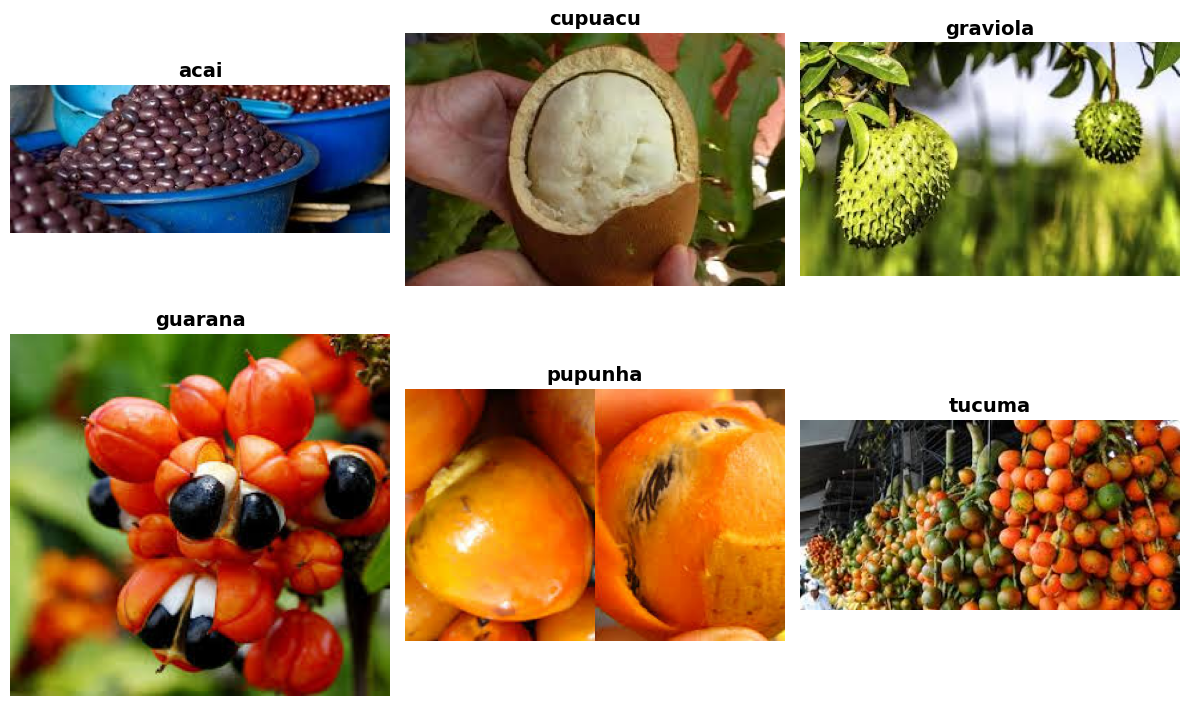

In [113]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

train_dir = '/content/drive/MyDrive/FruitinAmazon/train'

class_dirs = sorted([f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))])[:6]
if len(class_dirs) < 6:
    raise ValueError("Not enough classes in dataset. Ensure there are at least 6 class directories.")

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(train_dir, class_dir)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    if not image_files:
        axes[i].axis('off')
        axes[i].set_title(f"{class_dir} (No Image)", fontsize=12, color='red')
        continue

    image_path = os.path.join(class_path, random.choice(image_files))
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_dir, fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [114]:
def check_corrupted_images(train_dir, remove=False):
    corrupted = []
    for class_dir in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_dir)
        if not os.path.isdir(class_path): continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if not img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')): continue
            try:
                Image.open(img_path).verify()
            except:
                corrupted.append(img_path)
                if remove: os.remove(img_path)
    return corrupted

corrupt_files = check_corrupted_images(train_dir, remove=False)
print(f"Corrupted images: {len(corrupt_files)}")
if corrupt_files: print("\n".join(corrupt_files))

Corrupted images: 0


In [115]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

In [116]:
import tensorflow as tf


img_height, img_width, batch_size, validation_split = 128, 128, 32, 0.2
rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
).map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
).map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [117]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    # Data Augmentation
    data_augmentation,
    # Normalization
    layers.Rescaling(1./255),
    # Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    # Classifier
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_dirs), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_28 (Rescaling)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_67               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_68               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,680,230 (33.11 MB)

 Trainable params: 8,678,822 (33.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [118]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [119]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint_callback = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 1/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2422 - loss: 3.0978
Epoch 1: val_loss improved from inf to 1.77682, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 707ms/step - accuracy: 0.2461 - loss: 3.0244 - val_accuracy: 0.1667 - val_loss: 1.7768
Epoch 2/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.3281 - loss: 2.4000
Epoch 2: val_loss did not improve from 1.77682
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.3377 - loss: 2.3086 - val_accuracy: 0.1667 - val_loss: 1.8554
Epoch 3/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4844 - loss: 1.7659
Epoch 3: val_loss did not improve from 1.77682
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4783 - loss: 1.7218 - val_accuracy: 0.1667 - val_loss: 1.8427
Epoch 4/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5078 - loss: 1.3586
Epoch 4: val_loss did not improve from 1.77682
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.4970 - loss: 1.3623 - val_accuracy: 0.16

In [120]:
# Evaluating the model
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1667 - loss: 1.7768
Test Loss: 1.7768206596374512
Test Accuracy: 0.1666666716337204


In [121]:
model.save('fruit_classifier_model.h5')
loaded_model = models.load_model('fruit_classifier_model.h5')
test_loss, test_acc = loaded_model.evaluate(val_ds)
print(f"Test Loss (after loading): {test_loss}")
print(f"Test Accuracy (after loading): {test_acc}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step - accuracy: 0.1667 - loss: 1.7768
Test Loss (after loading): 1.7768206596374512
Test Accuracy (after loading): 0.1666666716337204


In [138]:
import numpy as np
from sklearn.metrics import classification_report
import os

train_dir = "/content/drive/MyDrive/FruitinAmazon/train"
class_dirs = sorted([class_name for class_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_name))])
num_classes = len(class_dirs)

y_pred = []
y_true = []
for images, labels in val_ds:
    pred = loaded_model.predict(images)
    y_pred.extend(np.argmax(pred, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))
all_labels = list(range(num_classes))
print(classification_report(y_true, y_pred, labels=all_labels, target_names=class_dirs))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
              precision    recall  f1-score   support

        acai       0.00      0.00      0.00         1
     cupuacu       0.00      0.00      0.00         2
    graviola       0.25      0.33      0.29         3
     guarana       0.31      0.80      0.44         5
     pupunha       0.00      0.00      0.00         4
      tucuma       0.00      0.00      0.00         3

    accuracy                           0.28        18
   macro avg       0.09      0.19      0.12        18
weighted avg       0.13      0.28      0.17        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [123]:
from tensorflow.keras.applications import VGG16
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [132]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation='relu')(x) # Fully connected layer with 1024 neurons
x = Dense(6, activation='softmax')(x) # Output layer for 10 classes (with softmax for multi-class classification)

In [133]:
from tensorflow.keras.models import Model
# Create the final model
model = Model(inputs=base_model.input, outputs=x)

In [134]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [135]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=validation_split,
    subset="training",
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=validation_split,
    subset="validation",
    seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [136]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.1706 - loss: 6.6468 - val_accuracy: 0.1111 - val_loss: 2.1451
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.3524 - loss: 1.6274 - val_accuracy: 0.2222 - val_loss: 2.1520
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.4093 - loss: 1.4869 - val_accuracy: 0.1667 - val_loss: 1.8416
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.5295 - loss: 1.3947 - val_accuracy: 0.2222 - val_loss: 1.7966
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.5964 - loss: 1.3112 - val_accuracy: 0.2778 - val_loss: 1.5898
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6289 - loss: 1.2129 - val_accuracy: 0.1667 - val_loss: 1.9970
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.5964 - loss: 1.0901 - val_accuracy: 0.4444 - val_loss: 1.4357
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.6350 - loss: 0.7637 - val_accuracy: 0.5000 - val_loss: 